In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import functools
import pickle
from operator import add
import matplotlib as mpl
from alpdesign.utils import *
from alpdesign.mlp import *
from jax_unirep import get_reps
import alpdesign
import os

In [2]:
AA_list = ['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V','B','Z','X','*']
blosum92 = np.loadtxt("./blosum62.txt", dtype='i', delimiter=' ')

avg92 = jnp.sum(blosum92)/24/24
sum92 = 0.
for row in blosum92:
    for aa in row:
        sum92 += (aa-avg92)**2
std92 = jnp.sqrt(sum92 / 24/24)

def blosum(seq1, seq2):
    seqlist1 = list(seq1)
    seqlist2 = list(seq2)
    score = 0.
    for i in range(len(seqlist1)):
        idx1 = AA_list.index(seqlist1[i])
        idx2 = AA_list.index(seqlist2[i])
        score += (blosum92[idx1][idx2] - avg92)/std92
        #jax.nn.sigmoid(score/len(seqlist1))
    return score/len(seqlist1)

### global setting

In [3]:
target_seq = 'TARGETPEPTIDE'
key = jax.random.PRNGKey(0)
c = alpdesign.EnsembleBlockConfig()
#c = alpdesign.EnsembleBlockConfig(shape=(16,2), model_number=3)
forward_t, full_forward_t, seq_t , uncertainty_eval_t = alpdesign.build_e2e(c)
#def gen(k, n): return jax.random.normal(k, shape=(n, 13, 20))
train_t = full_forward_t
aconfig = AlgConfig()
c.shape = (
        #64,
        #32,
        16,
        2,)
c.dropout=0.2
aconfig.train_epochs = 10

In [4]:
with open('../10kseqs.txt') as f:
    readfile = f.readlines()
    random_seqs = f'{readfile[0]}'.split(' ')[:-1]
    

def get_blosum_labels(seqs):
    labels = []
    for seq in seqs:
        labels.append(blosum(target_seq, seq))
    labels = np.array(labels)

    return labels

def get_count_labels(seqs):
    return get_aanum(seqs)[:,0]

def get_aanum(seqs):
    aa_count = []
    for seq in seqs:
        seq_list = list(seq)
        aa_num = [float(seq_list.count(aa)) for aa in AA_list]
        aa_count.append(aa_num)
    aa_count = jnp.array(aa_count)
    return aa_count
def get_flat_ohc(seqs):
    return jnp.array([encode_seq(list(s)).flatten() for s in seqs])

batch_size = 8
def get_results(key, params, rep_list):
    means = []
    stds = []
    # need batch
    for i in range(0, len(rep_list)//batch_size):
    #for rep in rep_list:
        batch_reps = rep_list[i * batch_size: (i + 1) * batch_size]
        yhat = forward_t.apply(params, key, batch_reps)
        #print(yhat.shape)
        means.append(yhat[0])
        stds.append(yhat[1])
    return np.array(means), np.array(stds)

def get_single_results(key, params, rep_list):
    yhats = []
    for i in range(0, len(rep_list)//batch_size):
    # need batch
    #for rep in rep_list:
        batch_reps = rep_list[i*batch_size: (i+1)*batch_size]
        yhat = naive_forward_t.apply(params, key, batch_reps)
        yhats.append(yhat)
    return np.array(yhats)

In [5]:
validation_seqs = [random.choice(random_seqs) for i in range(50)]
validation_reps = get_reps(validation_seqs)[0]
validation_ohc = get_flat_ohc(validation_seqs)
#validation_reps = get_aanum(validation_seqs)
validation_labels = get_blosum_labels(validation_seqs)
test_seqs = [random.choice(random_seqs) for i in range(500)]
test_reps = get_reps(test_seqs)[0]
test_ohc = get_flat_ohc(test_seqs)
#test_reps = get_aanum(test_seqs)
test_labels = get_blosum_labels(test_seqs)
train_seqs = [random.choice(random_seqs) for i in range(100)]
train_reps = get_reps(train_seqs)[0]
train_ohc = get_flat_ohc(train_seqs)
#train_reps = get_aanum(train_seqs)
train_labels = get_blosum_labels(train_seqs)

In [6]:
def parity_plot(yhat, test_y):
    plt.scatter(test_y, yhat, c='lightskyblue', alpha=0.3)
    plt.plot( [-0.5,1.0],[-0.5,1.0], color='lightsalmon', linewidth=2)
    plt.title('Parity Plot')
    plt.xlim([-0.5, 1.0])
    plt.ylim([-0.5, 1.0])
    plt.xlabel('Ground truth')
    plt.ylabel('Predictions')
    plt.text(
    min(test_y) + 0.1,
    max(test_y) - 0.2,
    f"correlation = {np.corrcoef(test_y, yhat)[0,1]:.3f}",
    )
    plt.text(
    min(test_y) + 0.1,
    max(test_y) - 0.3,
    f"loss = {np.sqrt(np.mean((test_y - yhat)**2)):.3f}",
    )
    plt.grid()
    return plt


def calibration_plot(y_pred, y_std, test_labels):
    (exp_proportions, obs_proportions) = uct.get_proportion_lists_vectorized(y_pred, y_std, test_labels)
    plt.figure()
    ax = plt.gca()
    ax.plot(exp_proportions, obs_proportions, c="#1f77b4")
    #ax.set_title('Calibration Parity Plot %d' % num)
    ax.set_title('Calibration Plot')
    ax.set_xlabel("Predicted Proportion in Interval")
    ax.set_ylabel("Observed Proportion in Interval")
    ax.axis("square")
    ax.grid()
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.plot(exp_proportions, exp_proportions, '--', c='orange')
    ax.fill_between(exp_proportions, exp_proportions, obs_proportions, alpha=0.2)
    polygon_points = []
    for point in zip(exp_proportions, obs_proportions):
        polygon_points.append(point)
    for point in zip(reversed(exp_proportions), reversed(exp_proportions)):
        polygon_points.append(point)
    polygon_points.append((exp_proportions[0], obs_proportions[0]))
    polygon = Polygon(polygon_points)
    x, y = polygon.exterior.xy  # original data
    ls = LineString(np.c_[x, y])  # closed, non-simple
    lr = LineString(ls.coords[:] + ls.coords[0:1])
    mls = unary_union(lr)
    polygon_area_list = [poly.area for poly in polygonize(mls)]
    miscalibration_area = np.asarray(polygon_area_list).sum()
    ax.text(
            x=0.95,
            y=0.05,
            s="Miscalibration area = %.2f" % miscalibration_area,
            verticalalignment="bottom",
            horizontalalignment="right",
            fontsize="small",
        )

### Ensemble train cells

In [7]:
params, train_loss, val_loss = ensemble_train(
        key, train_t, c, train_ohc, train_labels, val_seqs=validation_ohc, val_labels=validation_labels, aconfig=aconfig
    )

training in progress


Text(0.5, 0, 'epochs')

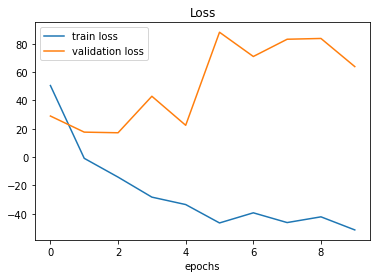

In [8]:
# ensemble plot
plt.figure()
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='validation loss')
plt.title('Loss')
plt.legend()
plt.xlabel('epochs')

In [9]:
y_pred, y_std = get_results(key, params, test_ohc)
train_y_pred, _ = get_results(key, params, train_ohc)

<module 'matplotlib.pyplot' from '/home/zyang43/.conda/envs/prettyB/lib/python3.9/site-packages/matplotlib/pyplot.py'>

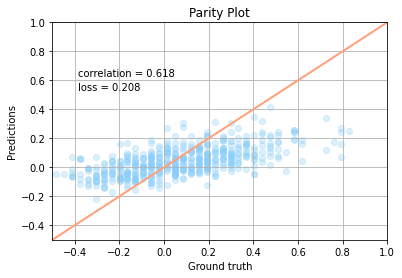

In [10]:
y_pred = y_pred.flatten()
parity_plot(y_pred, test_labels[:len(y_pred)])

<module 'matplotlib.pyplot' from '/home/zyang43/.conda/envs/prettyB/lib/python3.9/site-packages/matplotlib/pyplot.py'>

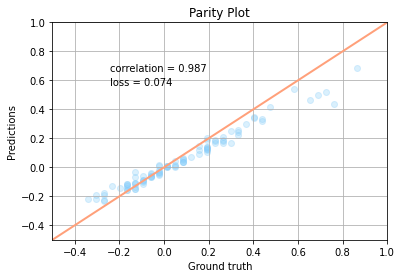

In [11]:
train_y_pred = train_y_pred.flatten()
parity_plot(train_y_pred, train_labels[:len(train_y_pred)])

### PCA analysis

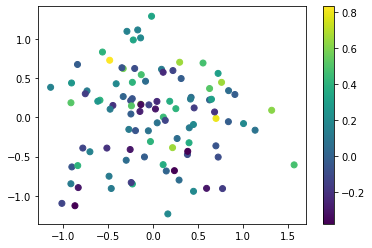

In [27]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_reps = pca.fit_transform(train_ohc)
plot = plt.scatter(pca_reps[:,0], pca_reps[:,1], c=train_labels)
plt.colorbar()

### Naive train cells

In [7]:
# test shape
batch_seqs = jnp.ones([8, train_ohc.shape[-1]])
params = alpdesign.mlp.naive_forward_t.init(key, batch_seqs)
out = alpdesign.mlp.naive_forward_t.apply(params, key, batch_seqs)
print(out.shape)

(8, 1)


In [11]:
def _naive_loss(forward, key, params, seq, label):
    yhat = forward(params, key, seq) #scalar
    return (label-yhat)**2
batch_labels = train_labels[:8]
naive_loss = _naive_loss(alpdesign.mlp.naive_forward_t.apply, key, params, batch_seqs, batch_labels)

In [12]:
batch_labels = batch_labels.reshape((-1, 1))
naive_loss = _naive_loss(alpdesign.mlp.naive_forward_t.apply, key, params, batch_seqs, batch_labels)
print(batch_seqs.shape)
print(batch_labels.shape)
print(naive_loss.shape)

(8, 260)
(8, 1)
(8, 1)


In [8]:
params, train_loss, val_loss = naive_train(
        key, alpdesign.mlp.naive_forward_t, train_ohc, train_labels, val_seqs=validation_ohc, val_labels=validation_labels, params=None
    )

Text(0.5, 0, 'epochs')

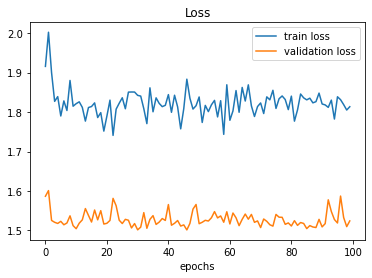

In [9]:
# naive plot
plt.figure()
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='validation loss')
plt.title('Loss')
plt.legend()
plt.xlabel('epochs')

In [10]:
y_pred = get_single_results(key, params, test_ohc)
train_y_pred= get_single_results(key, params, train_ohc)

<module 'matplotlib.pyplot' from '/home/zyang43/.conda/envs/prettyB/lib/python3.9/site-packages/matplotlib/pyplot.py'>

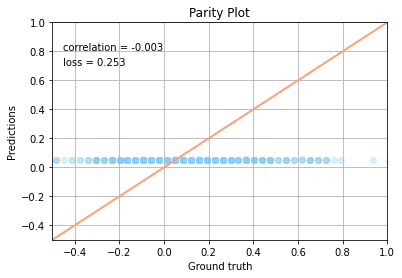

In [11]:
y_pred = y_pred.flatten()
parity_plot(y_pred, test_labels[:len(y_pred)])

<module 'matplotlib.pyplot' from '/home/zyang43/.conda/envs/prettyB/lib/python3.9/site-packages/matplotlib/pyplot.py'>

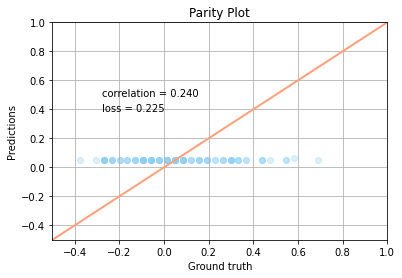

In [12]:
train_y_pred = train_y_pred.flatten()
parity_plot(train_y_pred, train_labels[:len(train_y_pred)])

(array([10., 12., 16., 13., 12., 15.,  9.,  5.,  4.,  4.]),
 array([-0.37692297, -0.26684222, -0.15676145, -0.0466807 ,  0.06340005,
         0.17348081,  0.28356156,  0.3936423 ,  0.5037231 ,  0.6138038 ,
         0.7238846 ], dtype=float32),
 <BarContainer object of 10 artists>)

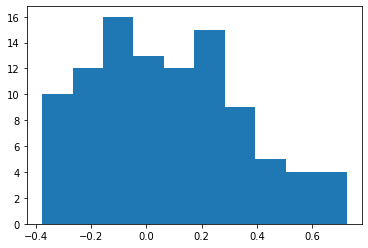

In [13]:
plt.hist(train_labels)

In [ ]:
#svm
#pca analysis
#prevent overfit